In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
def load_data(file_path):
    data = {f"{i:04b}": [] for i in range(16)}
    with open(file_path, 'r') as fp:
        lines = fp.readlines()

    for line in lines:
        if not line:
            continue
        l = line.strip().lstrip('[').rstrip(']')
        for l, v in zip(data.values(), l.split(',')):
            l.append(float(v.strip(' ')))

    return data

# JAQAL RAW
data = load_data('../data/QSCOUT/exp_data.txt')
jaqal_results = pd.DataFrame.from_dict(data)
jaqal_results[['1000', '0100', '0010', '0001']] = jaqal_results[['1000', '0100', '0010', '0001']].divide(jaqal_results[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
jaqal_results['avg_0100_1000'] = jaqal_results[['0100', '1000']].mean(axis=1)

In [3]:
run1 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_1.npy', allow_pickle=True) 
run2 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_2.npy', allow_pickle=True)
run3 = np.load('../data/QSCOUT/superstaq 2000 shots/Experiment Probabilities_3.npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = (np.mean([timestep[0][key], timestep[1][key], timestep[2][key]]))
    lines.append(timestep_data)
    
superstaq_results = pd.DataFrame(lines)

superstaq_results_norm = superstaq_results.copy()
superstaq_results_norm[['1000', '0100', '0010', '0001']] = superstaq_results_norm[['1000', '0100', '0010', '0001']].divide(superstaq_results_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
superstaq_results_norm['avg_0100_0010'] = superstaq_results_norm[['0100', '0010']].mean(axis=1)

In [4]:
N = 3
g = 2
kappa = 5
times = np.linspace(0, 3, 51)

In [5]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

In [6]:
qscout_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0010",
    "Cavity + Environment": "0001",
}

qscout_norm_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0010",
    "Cavity + Environment": "0001",
}

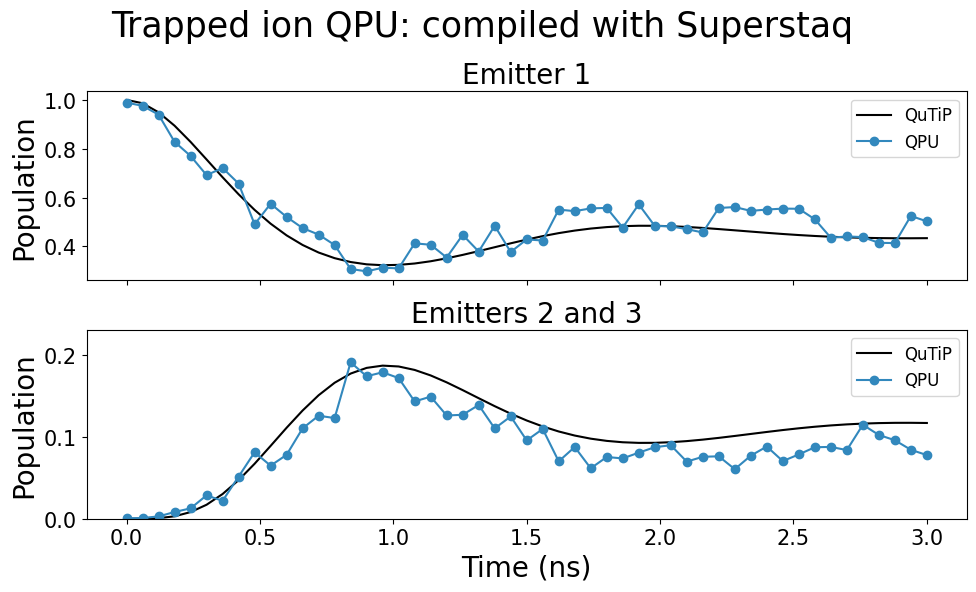

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].set_title("Emitter 1", fontsize=20)
axes[0].plot(qutip_results.index, qutip_results["Emitter 1"], label="QuTiP", color='black')
# axes[0].plot(times, superstaq_results["1000"], marker='o', label="QPU (raw)")
axes[0].plot(times, superstaq_results_norm["1000"], marker='o', label="QPU", color='#3288bd')
axes[0].set_ylabel("Population", fontsize=20)
axes[0].legend(fontsize=12)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].set_xticklabels([])

axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].plot(qutip_results.index, qutip_results["Emitter 2"], label="QuTiP", color='black')
# axes[1].plot(times, superstaq_results[qscout_bitstrs["Emitter 2"]], marker='o', label="QPU (raw, emitter 2)")
# axes[1].plot(times, superstaq_results[qscout_bitstrs["Emitter 3"]], marker='o', label="QPU (raw, emitter 3)")
axes[1].plot(times, superstaq_results_norm[qscout_norm_bitstrs["Emitter 2 and 3"]], marker='o', label="QPU", color='#3288bd')

axes[1].set_ylim(0, 0.23)
axes[1].set_ylabel("Population", fontsize=20)
axes[1].legend(fontsize=12)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)

axes[1].set_xlabel("Time (ns)", fontsize=20)

fig.suptitle("Trapped ion QPU: compiled with Superstaq", fontsize=25)
plt.tight_layout()

In [8]:
fig.savefig("../figures/QSCOUT_superstaq.eps")

In [9]:
from errorbars import calculate_mae_uncertainty, write_results_to_file

exp = superstaq_results_norm["1000"]
thy = qutip_results["Emitter 1"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 1", condition="Superstaq")

#######

exp = superstaq_results_norm[qscout_norm_bitstrs["Emitter 2 and 3"]]
thy = qutip_results["Emitter 2"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 2", condition="Superstaq")